# Gradient Boost Classifier (GBC) as model
*by Max*

In this notebook we will fit our data via a GBC model. In this specific case we choose the Classifier from [XGBoost](https://xgboost.readthedocs.io/en/stable/index.html). Here we use both, the raw band information and the calculated spectral indices. We start by loading the needed modules and the data. The folder structure differs depending on wether we are on Google Colab or in the local repository.

In [ ]:
# set the directory of the data
# depending on colab or vscode environment
on_colabs = True
import sys
if on_colabs:
  from google.colab import drive
  drive.mount("/content/drive")
  DATA_DIR = "/content/drive/MyDrive/Radiant_Earth_Spot_Crop/data"
  sys.path.append("/content/drive/MyDrive/Radiant_Earth_Spot_Crop/")
else:
  DATA_DIR = "../data"
  sys.path.append("../src/")

Mounted at /content/drive


We import the modules and set the plot style for the notebook.

In [ ]:
# import the needed modules
import numpy as np
import pandas as pd

# import the machine learning modules
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, DMatrix, cv
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import hyperopt.pyll.stochastic
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    log_loss, 
    confusion_matrix, 
    classification_report
    )

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import plotting modules and set the style
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(
    context="notebook", 
    style="darkgrid", 
    palette="crest", 
    font="helvetica"
    )
cmap = sns.color_palette("crest", 6) # six colors are created this way
sns.set(rc = {"figure.dpi":300})
sns.set(rc = {"figure.figsize":(6,3)})
sns.set(font_scale = 0.5)

# import own modules from the scr folder
from src.train_test_function import train_test_split_fields
from src.eda_functions import (
    plot_confusion_matrix, 
    get_label_accuracies, 
    plot_label_accuracy, 
    plot_feature_importance
    )

# set a random seed
RSEED = 42
np.random.seed(RSEED)

In [ ]:
# test the chosen color palette
sns.color_palette("crest", 6)

[(0.48942421, 0.72854938, 0.56751036),
 (0.34892097, 0.64828676, 0.56513633),
 (0.24929311, 0.56486397, 0.5586654),
 (0.15615526, 0.47913212, 0.54850526),
 (0.11131735, 0.39155635, 0.53422678),
 (0.14573579, 0.29354139, 0.49847009)]

We load the data from the CSV file. 

In [ ]:
# load the base data from the CSV files
df_train = pd.read_csv(f"{DATA_DIR}/Train_Dataset.csv")
df_train

,B05_10,B05_11,B05_5,B05_6,B05_7,B05_8,B05_9,homogeneity_10,homogeneity_11,homogeneity_5,...,B08_11,B08_5,B08_6,B08_7,B08_8,B08_9,field_id,field_size,tile_id,label
0,47.066226,60.103753,54.878586,43.344370,39.947021,35.663575,35.432672,0.400000,0.000000,0.500000,...,81.196470,68.816779,60.788080,84.348785,93.150994,97.092715,4,151,2526,8
1,48.382919,79.578805,54.212733,45.037269,40.535197,38.800078,33.677796,0.413707,0.485758,0.503335,...,94.514750,58.161490,54.506212,64.888199,88.352097,91.444875,14,644,979,8
2,93.371714,94.650908,90.118740,90.782387,87.399483,66.465379,78.149913,0.481771,0.508425,0.551671,...,109.695809,100.468482,106.841680,111.835061,95.225623,100.387565,20,579,632,8
3,56.779761,60.005952,45.738096,49.928570,41.966666,53.912699,54.015873,0.497820,0.389199,0.346870,...,72.660715,54.000000,62.452380,52.842857,65.865080,66.952380,25,42,1779,3
4,41.873684,56.456141,45.921054,33.447370,37.403509,39.526316,45.999999,0.430394,0.424396,0.424946,...,72.543862,66.065790,68.184213,82.324560,91.350873,64.526313,40,38,229,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44576,68.203273,64.634365,59.737983,51.271318,55.125970,52.986219,43.156589,0.399245,0.390108,0.366199,...,79.904392,73.469766,68.263570,78.359495,82.403963,64.767442,122575,129,328,5
44577,96.803281,101.964194,75.599474,71.964670,83.225678,84.604493,90.699685,0.409268,0.398346,0.422811,...,110.664669,81.275605,85.056782,95.474134,95.039117,102.597789,122598,1585,1866,5
44578,67.314020,73.899668,62.488168,59.667926,56.018963,46.473018,61.661671,0.436372,0.445108,0.454173,...,85.550357,70.924150,74.264360,80.354241,71.538568,83.278091,122628,1851,1289,5
44579,69.728487,73.202357,60.672560,57.299608,60.242140,34.879175,63.662739,0.434653,0.426423,0.386597,...,87.736248,68.734774,68.833985,76.796169,47.727897,86.475440,122662,509,2434,5


In [ ]:
df_test = pd.read_csv(f"{DATA_DIR}/Test_Dataset.csv")
df_test

,B05_10,B05_11,B05_5,B05_6,B05_7,B05_8,B05_9,homogeneity_10,homogeneity_11,homogeneity_5,...,B08_11,B08_5,B08_6,B08_7,B08_8,B08_9,field_id,label,field_size,tile_id
0,43.304949,68.831298,46.767997,37.622110,32.889460,19.370437,25.796916,0.388064,0.378303,0.386927,...,83.445373,61.946658,55.699230,82.179950,96.634448,96.678662,3,6,778,2214
1,43.950536,41.296867,57.220805,41.645638,34.641051,29.107047,41.380089,0.415163,0.411353,0.434272,...,50.307495,63.601510,54.908726,73.517560,93.320720,71.391385,8,8,2980,2318
2,101.356441,101.278569,102.184650,83.153490,79.975000,73.456909,82.815526,0.459310,0.463322,0.484458,...,114.428853,113.999109,100.648860,107.483690,100.978277,102.715811,22,3,1404,620
3,53.585843,55.607090,55.573041,49.724913,49.746942,47.324264,53.170369,0.449177,0.459472,0.498219,...,69.255758,65.658012,63.567483,77.569519,83.626123,81.631802,23,2,2003,125
4,46.678705,59.753727,52.706119,37.339237,40.268096,23.644222,36.255980,0.434685,0.393566,0.446487,...,76.352517,65.041005,51.334576,73.654862,82.277263,81.418763,26,7,1073,920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24038,70.418360,75.736063,64.764737,53.179878,61.508129,60.332318,61.215701,0.381330,0.367584,0.329536,...,91.809667,77.403457,67.867378,82.497629,86.313413,83.608231,122725,5,328,2128
24039,54.866784,55.917619,50.432689,36.815464,33.763746,25.541300,36.806327,0.357733,0.384728,0.392238,...,68.102813,61.439015,52.462213,78.571426,94.217927,83.955713,122727,6,569,2456
24040,40.621539,41.886326,37.692309,34.578205,34.170086,34.002563,36.135897,0.325433,0.358012,0.415385,...,74.335897,56.743589,59.243592,67.834187,75.974360,84.238460,122729,1,390,766
24041,73.576211,83.922175,69.032310,57.421440,61.195056,61.457270,68.499262,0.395872,0.395296,0.370391,...,93.379738,76.647089,64.913364,77.413117,79.427603,84.295155,122732,5,681,2225


---
## Train-test split, validation split & resampling
After loading the modules and data, we perform the train-test split and also the validation split. Validation split means we create a second "train" and "validation" dataset from the actual training data. This is done to train and test our model on this validation data before we apply the model to the real test data. 

In [ ]:
# do the train-test-split
df_train, df_val = train_test_split_fields(
    df, train_size=0.7, random_state=RSEED
    )

In [ ]:
df_train

,B05_10,B05_11,B05_5,B05_6,B05_7,B05_8,B05_9,homogeneity_10,homogeneity_11,homogeneity_5,...,B08_11,B08_5,B08_6,B08_7,B08_8,B08_9,field_id,field_size,tile_id,label
0,47.066226,60.103753,54.878586,43.344370,39.947021,35.663575,35.432672,0.400000,0.000000,0.500000,...,81.196470,68.816779,60.788080,84.348785,93.150994,97.092715,4,151,2526,8
1,48.382919,79.578805,54.212733,45.037269,40.535197,38.800078,33.677796,0.413707,0.485758,0.503335,...,94.514750,58.161490,54.506212,64.888199,88.352097,91.444875,14,644,979,8
3,56.779761,60.005952,45.738096,49.928570,41.966666,53.912699,54.015873,0.497820,0.389199,0.346870,...,72.660715,54.000000,62.452380,52.842857,65.865080,66.952380,25,42,1779,3
4,41.873684,56.456141,45.921054,33.447370,37.403509,39.526316,45.999999,0.430394,0.424396,0.424946,...,72.543862,66.065790,68.184213,82.324560,91.350873,64.526313,40,38,229,3
5,41.616310,49.647148,58.205110,78.251513,37.932621,36.332085,37.725370,0.500625,0.460136,0.439061,...,61.515865,67.731073,84.271123,74.009745,102.753210,99.261913,44,2805,920,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44573,71.604097,66.131803,58.936066,44.649180,58.899178,55.774426,58.284152,0.351360,0.397918,0.360028,...,84.474752,68.816395,54.211475,71.696721,74.368524,87.500547,122524,305,1925,5
44575,86.175001,100.996598,76.973809,60.005953,66.038690,63.482143,71.547619,0.402289,0.414027,0.362360,...,115.047619,90.116664,73.351187,83.830356,81.824406,89.851191,122557,84,657,5
44576,68.203273,64.634365,59.737983,51.271318,55.125970,52.986219,43.156589,0.399245,0.390108,0.366199,...,79.904392,73.469766,68.263570,78.359495,82.403963,64.767442,122575,129,328,5
44579,69.728487,73.202357,60.672560,57.299608,60.242140,34.879175,63.662739,0.434653,0.426423,0.386597,...,87.736248,68.734774,68.833985,76.796169,47.727897,86.475440,122662,509,2434,5


In [ ]:
df_val

,B05_10,B05_11,B05_5,B05_6,B05_7,B05_8,B05_9,homogeneity_10,homogeneity_11,homogeneity_5,...,B08_11,B08_5,B08_6,B08_7,B08_8,B08_9,field_id,field_size,tile_id,label
2,93.371714,94.650908,90.118740,90.782387,87.399483,66.465379,78.149913,0.481771,0.508425,0.551671,...,109.695809,100.468482,106.841680,111.835061,95.225623,100.387565,20,579,632,8
9,33.500000,49.400000,41.100000,33.200000,33.785714,33.280000,34.000000,0.000000,0.000000,0.000000,...,70.300000,51.250000,52.300000,64.114286,92.680000,88.025000,100,10,1366,8
10,70.274523,73.691305,71.279811,59.910565,63.584518,54.854021,64.905334,0.361374,0.379198,0.380537,...,85.554396,82.350417,71.327928,82.119039,76.875639,88.151149,108,478,1173,1
12,59.079907,58.457307,47.720558,46.295755,49.448666,45.713386,48.776213,0.237639,0.248399,0.293913,...,67.709109,55.666457,56.528601,69.192099,68.483457,62.178408,128,1987,903,3
15,44.525607,48.074574,43.729110,32.045822,29.527404,31.169272,40.366577,0.295208,0.352021,0.216192,...,97.220127,54.443396,45.250675,46.220127,70.975741,61.160827,141,371,523,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44569,84.764253,88.061675,65.266448,74.817437,73.383220,73.676535,82.570725,0.432128,0.420428,0.421820,...,102.963816,71.262062,87.799340,90.814969,94.617323,101.805920,122436,304,2574,5
44572,53.223077,51.803846,47.756410,41.237180,42.846154,45.583334,49.735577,0.273196,0.294847,0.343127,...,57.696155,52.435898,48.102565,50.173076,53.961539,58.120191,122495,52,983,5
44574,83.626393,89.258900,81.636462,67.118127,68.515372,68.069041,65.851940,0.361501,0.363835,0.442385,...,102.062877,92.552857,80.077670,88.877427,87.408486,80.384305,122552,309,2483,5
44577,96.803281,101.964194,75.599474,71.964670,83.225678,84.604493,90.699685,0.409268,0.398346,0.422811,...,110.664669,81.275605,85.056782,95.474134,95.039117,102.597789,122598,1585,1866,5


We set the features (X), i.e. our bands and indices, and also set the target (y). For the moment, only on the validation train and test data. Moreover we set the class labels to 0 - 8 instead of 1 - 9, since XGBClassifier cannot handle class labels starting at 1.

In [ ]:
# get X for the train and validation data
X_train = df_train.drop(columns=["label", "field_id", "tile_id"])
X_val = df_test.drop(columns=["label", "field_id", "tile_id"])

# get y for the train and validation data
y_train = df_train["label"]
y_train = y_train.astype(int)
y_val = df_test["label"]
y_val = y_val.astype(int)

# set the class labels from 0 to 8 
y_train = y_train-1
y_val = y_val-1

---
## Modelling with XGBoost
We will start this process by using the XGBClassifier with the default hyperparameters. We only set the objective, evaluation metric, the random seed, enable support of all cores and also GPU support. 
- for the `objective` we only have two choices: multi:softprob and multi:softmax, which only differentiated in that the softmax gives back the actual classes, whereas the softprob gives back the probabilities for each class label. For the multi:... objective we also have to set the `num_class` to the number of available classes in the target. And we have to `disable_default_eval_metric=1` for it to actually work.
- for the `random_state` we set our RSEED value.
- for the `eval_metric`, we decide to use the mlogloss because the logloss (cross entropy) is our main target along with the F1-score. The mlogloss is the logloss for multiple classes.
- `n_jobs=-1` enables all CPU cores
- for GPU support we need to set the `tree_method='gpu_hist'` and `gpu_id=0`

We initialize the model and train it.

In [ ]:
# initialize a default GradientBoostingClassifier
xgb = XGBClassifier(
    objective='multi:softprob', 
    num_class='9',
    eval_metric='mlogloss', 
    disable_default_eval_metric=1, 
    random_state=RSEED,
    n_jobs=-1, 
    tree_method='gpu_hist', 
    gpu_id=0
    )
xgb.fit(X_train, y_train)

XGBClassifier(disable_default_eval_metric=1, eval_metric='mlogloss', gpu_id=0,
              n_jobs=-1, num_class='9', objective='multi:softprob',
              random_state=42, tree_method='gpu_hist')

Then we do the predictions on the validation train (`X_train`) and validation test data (`X_val`). 

In [ ]:
# predict the absolute classes and probabilities
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)

# predict the probabilities for each  class
y_proba_train = xgb.predict_proba(X_train)
y_proba_val = xgb.predict_proba(X_val)

For the `evaluation metrics` we will mainly focus on the `F1-score`, since we want to classify as many labels right as possible. We do not care for an especially high recall or precision. In addition, we look at the `cross-entropy (log loss)`, as this was the target metric of the [Zindi challenge](https://zindi.africa/competitions/radiant-earth-spot-the-crop-challenge/data) from which we got the data. They were interested in the probability of the crop type of each field. 

In [ ]:
print("---" * 12)
print(f"Accuracy on train data: {round(accuracy_score(y_train, y_pred_train), 3)}")
print(f"Accuracy on test data: {round(accuracy_score(y_val, y_pred_val), 3)}")
print("---" * 12)
print(f'F1-score on train data: {round(f1_score(y_train, y_pred_train, average="macro"), 3)}')
print(f'F1-score on test data: {round(f1_score(y_val, y_pred_val, average="macro"), 3)}')
print("---" * 12)
print(f"Cross-entropy on train data: {round(log_loss(y_train, y_proba_train), 3)}")
print(f"Cross-entropy on test data: {round(log_loss(y_val, y_proba_val), 3)}")
print("---" * 12)

------------------------------------
Accuracy on train data: 0.6
Accuracy on test data: 0.554
------------------------------------
F1-score on train data: 0.595
F1-score on test data: 0.548
------------------------------------
Cross-entropy on train data: 1.139
Cross-entropy on test data: 1.23
------------------------------------


We see the the model performs not bad. However, there is still room for improvement. An accuracy and F1-score of 0.6 is ok for the beginning. Nevertheless we need to push the cross-entropy below 1.0.

---
## Hyperparameter tuning via Bayesian optimization
The next step is the tuning of the hyperparameters. We will try a new method, the Bayesian optimization via the [Hyperopt module](http://hyperopt.github.io/hyperopt/). Bayesian optimization is a sequential design strategy for global optimization of black-box functions that does not assume any functional forms. It is usually employed to optimize expensive-to-evaluate functions ([wikipedia](https://en.wikipedia.org/wiki/Bayesian_optimization)).

The first step to using `Hyperopt` is to create a `space of hyperparameters` that you want to optimize. The program offers several options to randomly select a value for each hyperparameter. 
The here used options are:
- `hp.choice`: this just makes a random choice between the given arguments
- `hp.uniform`: this chooses a float value between a given start and a given end value
- `hp.quniform`: selects a value between a given start and end value that is a multiple of the last given value. For example, if you use 1 as the last value you will get an integer as result.

It is important that for each of the hp. functions you first enter the name of the hyperparameter and then the values from which the function can choose.

In [ ]:
# hp.uniform for float number
# hp.quniform for int that are a multiple from the last number, 
# for example 3, 15, 1 means any whole number between 3 and 15
space={
    'objective': hp.choice('objective', ('multi:softmax', 'multi:softprob')),
    'n_estimators': 150,
    'random_state': RSEED,
    'disable_default_eval_metric': 1,
    'gpu_id':0,
    'tree_method': 'gpu_hist',
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 3, 1),
    'gamma': hp.uniform ('gamma', 0, 0.3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'learning_rate': hp.uniform('learning_rate', 0, 1)
    }
print(hyperopt.pyll.stochastic.sample(space))

{'colsample_bytree': 0.736159237155108, 'disable_default_eval_metric': 1, 'gamma': 0.24924162659401228, 'gpu_id': 0, 'learning_rate': 0.8229841987817796, 'max_depth': 6.0, 'min_child_weight': 1.0, 'n_estimators': 150, 'objective': 'multi:softmax', 'random_state': 42, 'tree_method': 'gpu_hist'}


The next step defines our `objective function`. 
- This function should contain the `initialization of the model`, which passes the hyperparameter space (dictionary) to each hyperparameter. 
- It must also contain the `training of the model` and the `calculation of the evaluation`. 
- The function must `return the score to be optimized` by Hyperopt. Since Hyperopt tries to minimize scores, a minus must be put in front of the scores like the F1 score. 

In [ ]:
def objective(space):
    clf = XGBClassifier(
        objective=space['objective'],
        n_estimators=space['n_estimators'],
        random_state=space['random_state'],
        disable_default_eval_metric=space['disable_default_eval_metric'],
        gpu_id=space['gpu_id'],
        tree_method=space['tree_method'],
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        gamma=space['gamma'],
        colsample_bytree=int(space['colsample_bytree']),
        learning_rate=space['learning_rate']
    )
    
    evaluation = [
                  ( X_train, y_train), 
                  ( X_val, y_val)
    ]
                
    clf.fit(
        X_train, y_train,
        eval_set=evaluation, 
        eval_metric="mlogloss",
        early_stopping_rounds=10,
        verbose=False
    )
    
    y_pred_val = clf.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

Then we can start the `optimization process` via hyperopts `Trials class`. This takes minimizes (fmin) the objective function on the hyperparameter space. The number of optimization steps can be set via `max_evals`. 

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

SCORE:
0.49519149538597856
SCORE:
0.43625955181046283
SCORE:
0.4761490026682571
SCORE:
0.4452765679734516
SCORE:
0.4641101107595912
SCORE:
0.4654561015010417
SCORE:
0.45620391316078446
SCORE:
0.482392049949437
SCORE:
0.41181006148820676
SCORE:
0.4428028957375958
SCORE:
0.43915165593993
SCORE:
0.4736440686686293
SCORE:
0.4894075081140371
SCORE:
0.5047486039608587
SCORE:
0.49684774339689525
SCORE:
0.46315697070437056
SCORE:
0.48758524948826837
SCORE:
0.41623347756427437
SCORE:
0.4503970992662611
SCORE:
0.44308409724030856
SCORE:
0.4901217934399057
SCORE:
0.5088376424077699
SCORE:
0.508783485225116
SCORE:
0.5091883786478897
SCORE:
0.47341485695084007
SCORE:
0.4816580561731987
SCORE:
0.5062922035948894
SCORE:
0.5001664478167233
SCORE:
0.4854015703982127
SCORE:
0.5067519478110614
SCORE:
0.4761610494778756
SCORE:
0.49990065334697786
SCORE:
0.47250435054570494
SCORE:
0.44528710063511884
SCORE:
0.49779535129010044
SCORE:
0.4940506725070237
SCORE:
0.46447317732525145
SCORE:
0.5060913659142248
S

Finally we can get the best parameters from the optimization process.

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8105532874328871, 'gamma': 0.28078431210934557, 'learning_rate': 0.5859073717301008, 'max_depth': 3.0, 'min_child_weight': 3.0, 'objective': 1}


---
## Train_Dataset1 - improvement via Bayesian optimization



In [ ]:
# hp.uniform for float number
# hp.quniform for int that are a multiple from the last number, 
# for example 3, 15, 1 means any whole number between 3 and 15
space={
    'objective': 'multi:softmax',
    'n_estimators': hp.quniform('n_estimators', 300, 2000, 10),
    'random_state': RSEED,
    'disable_default_eval_metric': 1,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'max_depth': hp.quniform('max_depth', 3, 5, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform ('gamma', 0, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'learning_rate': hp.uniform('learning_rate', 0.05, 5),
    'reg_lambda': hp.uniform('reg_lambda', 2, 20),
    'reg_alpha': hp.uniform('reg_alpha', 2, 20),
    'subsample': hp.uniform('subsample', 0, 1),
    'scale_pos_weight': 1
    }
print(hyperopt.pyll.stochastic.sample(space))

{'colsample_bytree': 0.6383739667105567, 'disable_default_eval_metric': 1, 'gamma': 2.2276540344181717, 'gpu_id': 0, 'learning_rate': 3.370844435230291, 'max_depth': 4.0, 'min_child_weight': 6.0, 'n_estimators': 1230.0, 'objective': 'multi:softmax', 'random_state': 42, 'reg_alpha': 18.304780838893844, 'reg_lambda': 2.940489892001258, 'scale_pos_weight': 1, 'subsample': 0.7921134507846322, 'tree_method': 'gpu_hist'}


In [ ]:
def objective(space):
    clf = XGBClassifier(
        objective=space['objective'],
        n_estimators=int(space['n_estimators']),
        random_state=space['random_state'],
        disable_default_eval_metric=space['disable_default_eval_metric'],
        gpu_id=space['gpu_id'],
        tree_method=space['tree_method'],
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        gamma=space['gamma'],
        colsample_bytree=space['colsample_bytree'],
        learning_rate=space['learning_rate'],
        reg_lambda=space['reg_lambda'],
        reg_alpha=space['reg_alpha'],
        subsample=space['subsample'],
        scale_pos_weight=space['scale_pos_weight']
    )
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    clf.fit(
        X_train, y_train,
        eval_set=evaluation, 
        eval_metric="mlogloss",
        early_stopping_rounds=10,
        verbose=False
    )
    
    y_pred_train = clf.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train, average="macro")
    y_pred_val = clf.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")
    print (f"SCORE: {f1:.4f}    |   SCORE on TRAIN: {f1_train:.4f}")
    return {'loss': -f1, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE: 0.4368    |   SCORE on TRAIN: 0.4372
SCORE: 0.6107    |   SCORE on TRAIN: 0.7114
SCORE: 0.5303    |   SCORE on TRAIN: 0.5890
SCORE: 0.5155    |   SCORE on TRAIN: 0.5561
SCORE: 0.4557    |   SCORE on TRAIN: 0.4519
SCORE: 0.5714    |   SCORE on TRAIN: 0.6532
SCORE: 0.5451    |   SCORE on TRAIN: 0.6021
SCORE: 0.4604    |   SCORE on TRAIN: 0.4641
SCORE: 0.4366    |   SCORE on TRAIN: 0.4375
SCORE: 0.4579    |   SCORE on TRAIN: 0.4565
SCORE: 0.6192    |   SCORE on TRAIN: 0.7766
SCORE: 0.4675    |   SCORE on TRAIN: 0.4731
SCORE: 0.6184    |   SCORE on TRAIN: 0.7516
SCORE: 0.4727    |   SCORE on TRAIN: 0.4795
SCORE: 0.5305    |   SCORE on TRAIN: 0.6036
SCORE: 0.4605    |   SCORE on TRAIN: 0.4688
SCORE: 0.4491    |   SCORE on TRAIN: 0.4489
SCORE: 0.4690    |   SCORE on TRAIN: 0.4782
SCORE: 0.6003    |   SCORE on TRAIN: 0.8317
SCORE: 0.5605    |   SCORE on TRAIN: 0.6793
SCORE: 0.6192    |   SCORE on TRAIN: 0.7502
SCORE: 0.6225    |   SCORE on TRAIN: 0.8123
SCORE: 0.6211    |   SCORE on TR

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6957199717752605, 'gamma': 3.4604737820310962, 'learning_rate': 0.05422223805154701, 'max_depth': 5.0, 'min_child_weight': 7.0, 'n_estimators': 1580.0, 'reg_alpha': 8.556367593625488, 'reg_lambda': 15.229692597388414, 'subsample': 0.6315449013169167}


{'colsample_bytree': 0.8422068815687349, 'gamma': 1.8529884122385991, 'learning_rate': 0.05002485997505423, 'max_depth': 6.0, 'min_child_weight': 6.0, 'n_estimators': 1660.0, 'reg_alpha': 4.345715646170847, 'reg_lambda': 1.5931904751368657, 'subsample': 0.6685120429613557}

In [ ]:
run = 37
print(trials.results[run])
hyperparams_to_use = trials.trials[run]['misc']['vals']

{'loss': -0.61221468752708, 'status': 'ok'}


In [ ]:
hyperparams_to_use

{'colsample_bytree': [0.6362412959605761],
 'gamma': [3.535720977345191],
 'learning_rate': [0.05986321632365238],
 'max_depth': [3.0],
 'min_child_weight': [2.0],
 'n_estimators': [1900.0],
 'reg_alpha': [8.017165700677694],
 'reg_lambda': [10.181700840893257],
 'subsample': [0.34236532966944233]}

In [ ]:
# initialize a default GradientBoostingClassifier
xgb = XGBClassifier(
    objective='multi:softmax', 
    n_estimators=int(hyperparams_to_use['n_estimators'][0]),
    random_state=RSEED,
    disable_default_eval_metric=1,
    gpu_id=0,
    tree_method='gpu_hist',
    max_depth=int(hyperparams_to_use['max_depth'][0]),
    min_child_weight=int(hyperparams_to_use['min_child_weight'][0]),
    gamma=hyperparams_to_use['gamma'][0],
    colsample_bytree=hyperparams_to_use['colsample_bytree'][0],
    learning_rate=hyperparams_to_use['learning_rate'][0],
    reg_lambda=hyperparams_to_use['reg_lambda'][0],
    reg_alpha=hyperparams_to_use['reg_alpha'][0],
    subsample=hyperparams_to_use['subsample'][0],
    scale_pos_weight=1
    )
xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.6362412959605761,
              disable_default_eval_metric=1, gamma=3.535720977345191, gpu_id=0,
              learning_rate=0.05986321632365238, min_child_weight=2,
              n_estimators=1900, objective='multi:softprob', random_state=42,
              reg_alpha=8.017165700677694, reg_lambda=10.181700840893257,
              subsample=0.34236532966944233, tree_method='gpu_hist')

In [ ]:
# predict the absolute classes and probabilities
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)

# predict the probabilities for each  class
y_proba_train = xgb.predict_proba(X_train)
y_proba_val = xgb.predict_proba(X_val)

print("---" * 12)
print(f"Accuracy on train data: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Accuracy on test data: {accuracy_score(y_val, y_pred_val):.4f}")
print("---" * 12)
print(f'F1-score on train data: {f1_score(y_train, y_pred_train, average="macro"):.4f}')
print(f'F1-score on test data: {f1_score(y_val, y_pred_val, average="macro"):.4f}')
print("---" * 12)
print(f"Cross-entropy on train data: {log_loss(y_train, y_proba_train):.4f}")
print(f"Cross-entropy on test data: {log_loss(y_val, y_proba_val):.4f}")
print("---" * 12)

------------------------------------
Accuracy on train data: 0.7408
Accuracy on test data: 0.6667
------------------------------------
F1-score on train data: 0.7390
F1-score on test data: 0.6164
------------------------------------
Cross-entropy on train data: 0.7905
Cross-entropy on test data: 0.9483
------------------------------------


## Error Analysis

In [ ]:
def plot_confusion_matrix(xgb_cm:confusion_matrix, labels:list):
    """Plots a nicely formatted confusion matrix. 

    Args:
        xgb_cm (sklearn.metrics.confusion_matrix): The confusion matrix to be plotted.
        labels (list): List of the class label names.
    """

    # setup the heatmap of the confusion matrix
    ax = sns.heatmap(xgb_cm, annot=True, cmap=cmap, fmt='g')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    # set the ticket labels
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=30, horizontalalignment='center') 

    # display the confusion matrix
    plt.show()

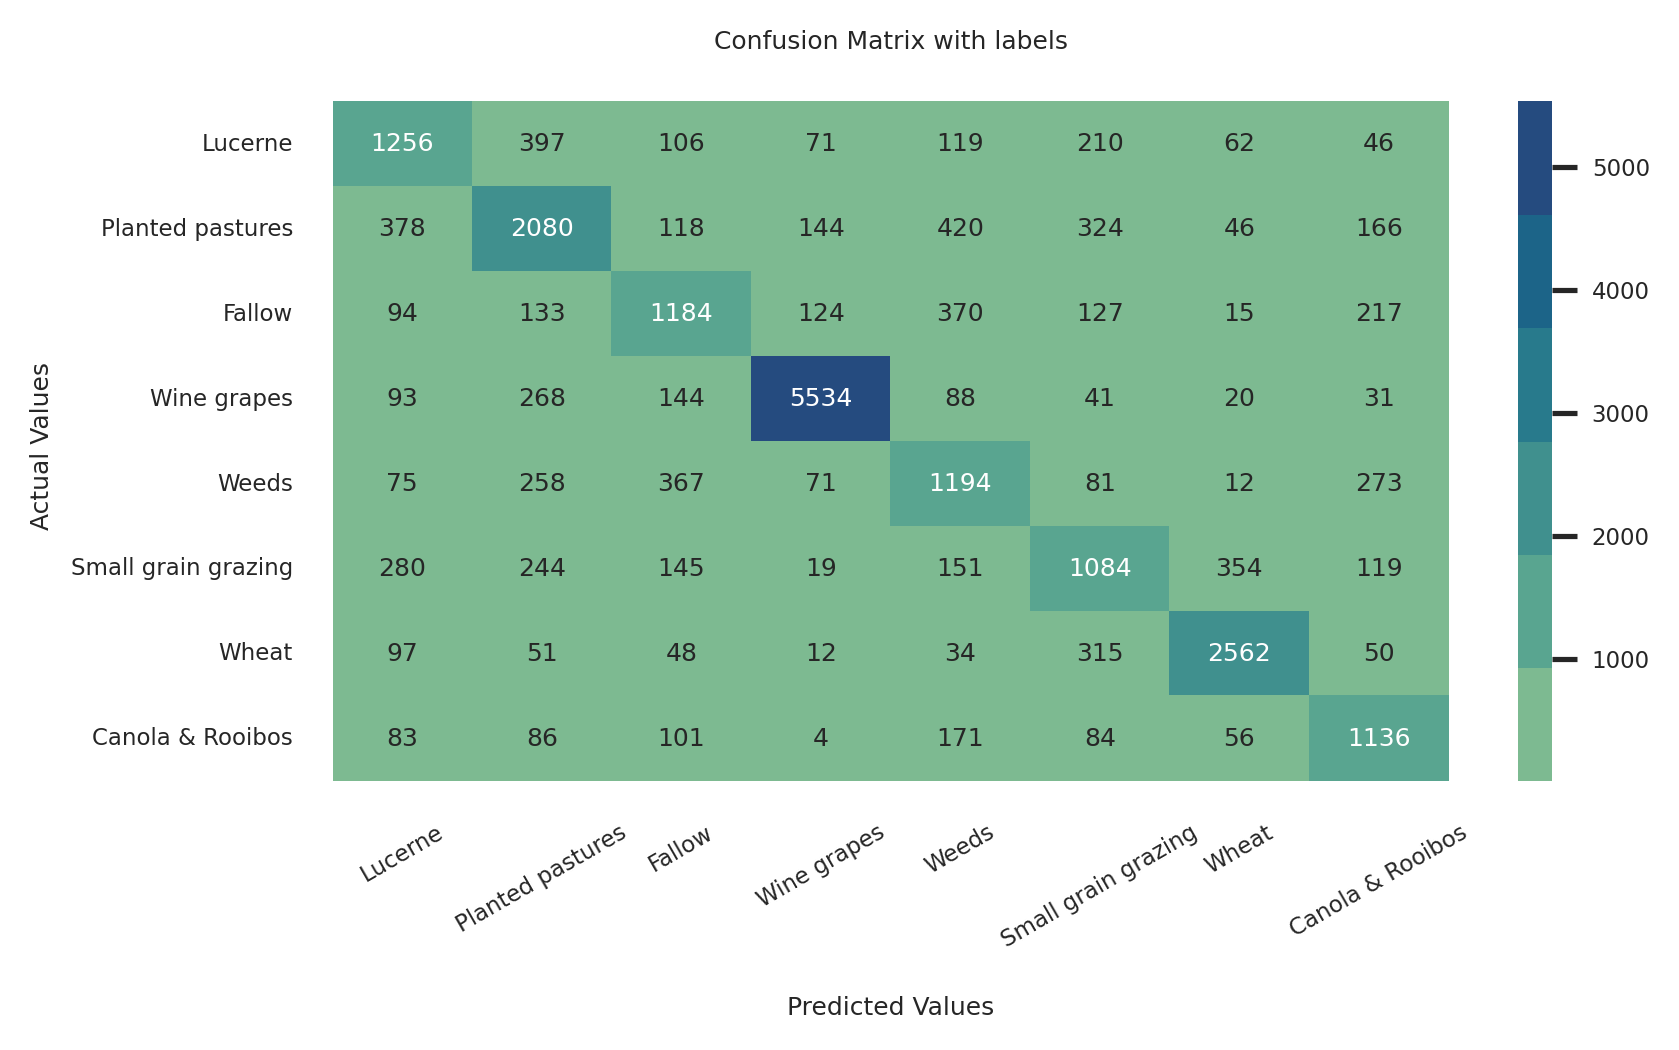

In [ ]:
# build the confusion matrix
xgb_cm = confusion_matrix(y_val, y_pred_val)

# set the class labels to the actual crop types
labels = [
          'Lucerne', 
          'Planted pastures', 
          'Fallow', 
          'Wine grapes', 
          'Weeds', 
          'Small grain grazing', 
          'Wheat', 
          'Canola & Rooibos'
]

# plot the confusion matrix of the validation data
plot_confusion_matrix(xgb_cm, labels)

In [ ]:
accuracies_df = get_label_accuracies(xgb_cm, labels)
accuracies_df

,crop_type,accuracy,often_confused_with,confusion_percent
3,Wine grapes,0.89,Planted pastures,4.84
6,Wheat,0.81,Small grain grazing,12.30
7,Canola & Rooibos,0.66,Weeds,15.05
1,Planted pastures,0.57,Weeds,20.19
0,Lucerne,0.55,Planted pastures,31.61
2,Fallow,0.52,Weeds,31.25
4,Weeds,0.51,Fallow,30.74
5,Small grain grazing,0.45,Wheat,32.66


In [ ]:
def plot_label_accuracy(df):
    # plot Searborn bar chart
    cmap = sns.color_palette("crest", 100)

    c_palette = [
                 cmap[0] if x >= 0.8
                 else cmap[50] if x >= 0.6
                 else cmap[99]
                 for x in df.accuracy
    ]

    ax = sns.barplot(
      data=df, 
      x='crop_type', 
      y='accuracy', 
      palette=c_palette
    )

    # do the annotation on each bar
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'), 
                      (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')


    # set chart labels
    ax.set_title('Accuracy of the different crop types\n')
    ax.set_xlabel('')
    ax.set_ylabel('Accuracy')

    # set the ticket labels
    plt.yticks(rotation=0) 
    plt.ylim(0, 1.1)
    plt.xticks(rotation=30, horizontalalignment='center')

    # display the bar chart of the label accuracies
    plt.show()

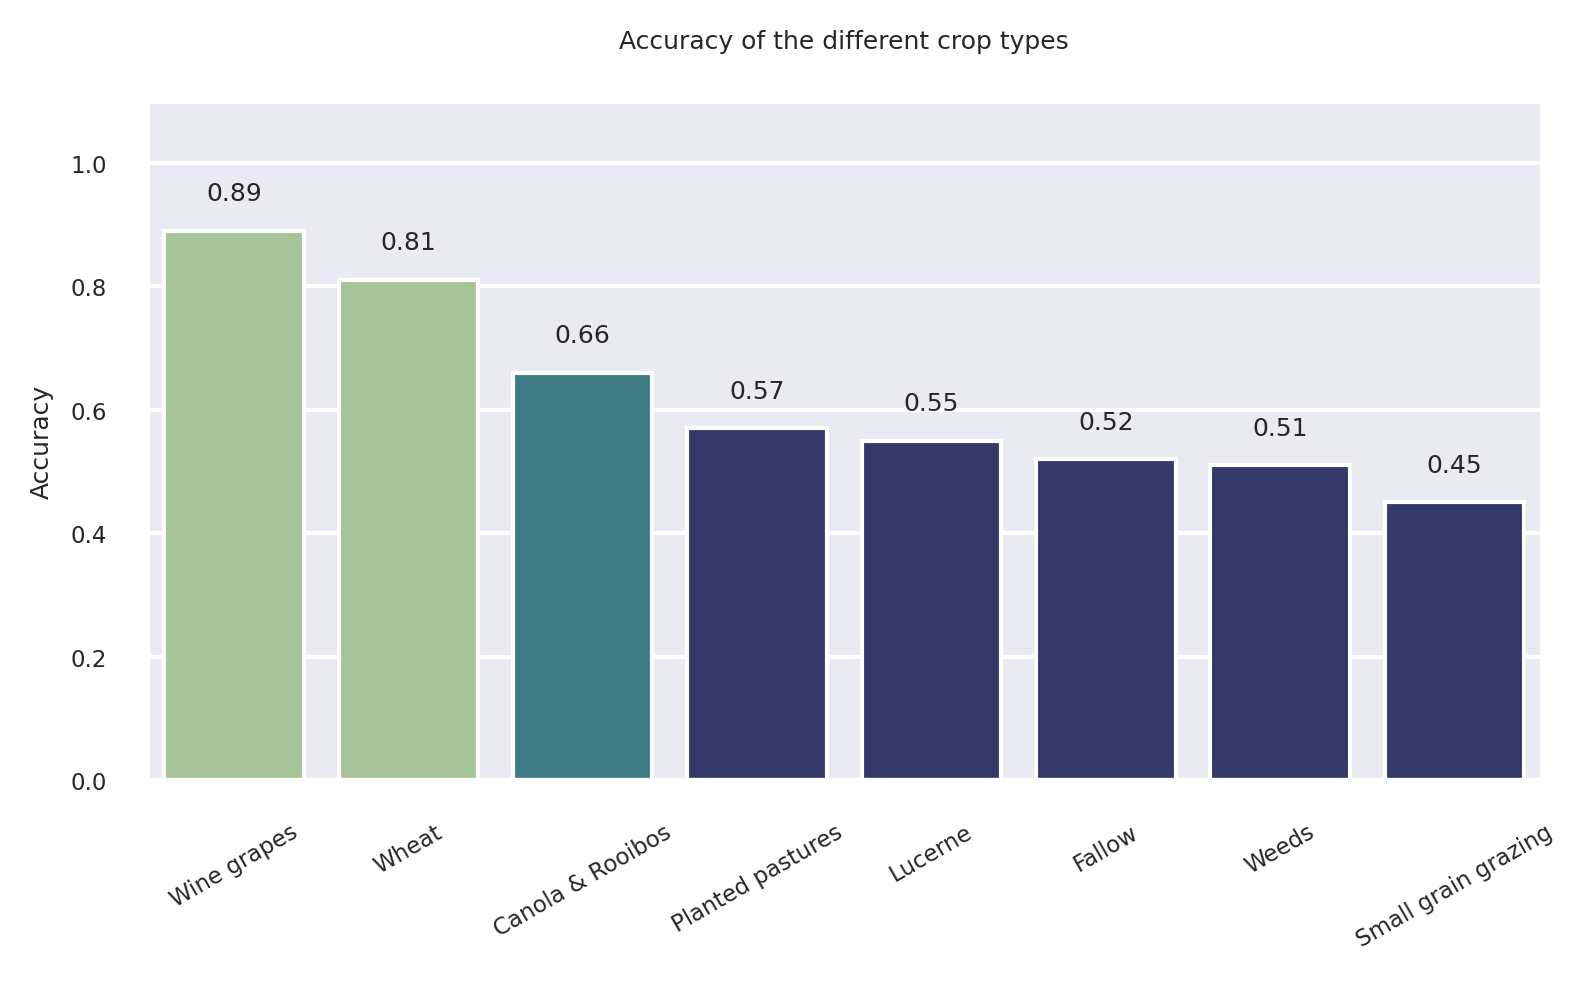

In [ ]:
plot_label_accuracy(accuracies_df)

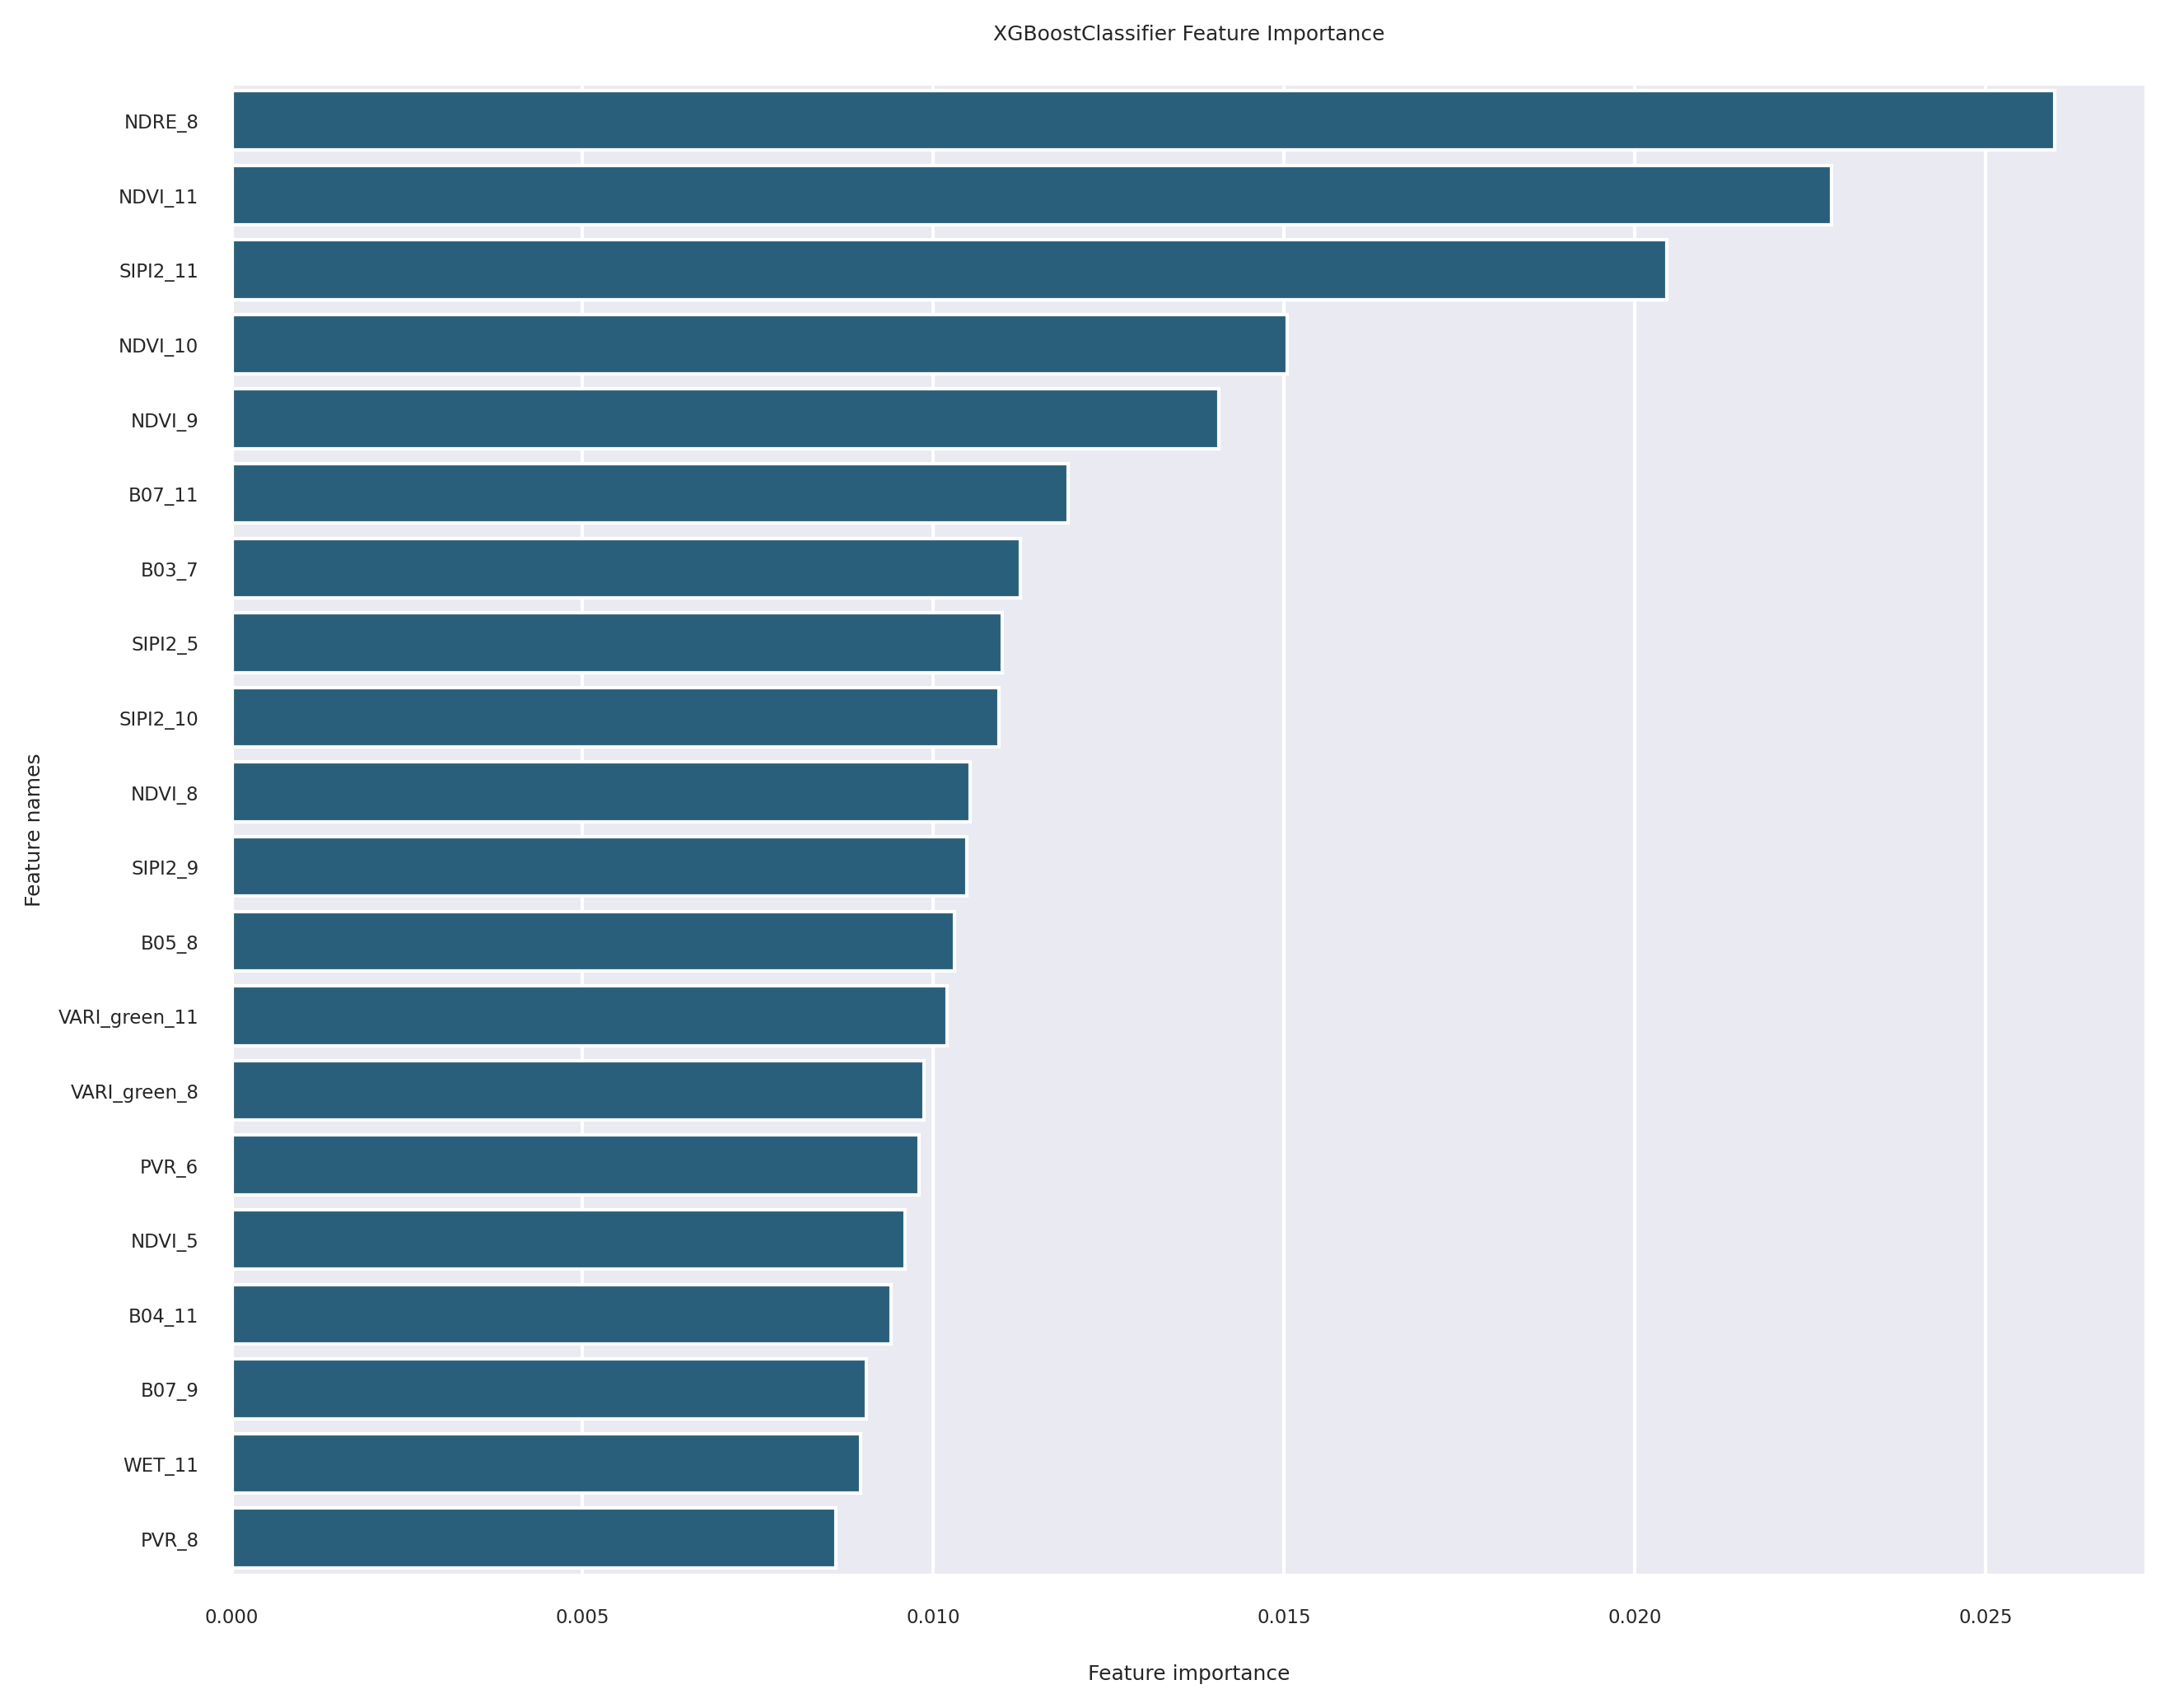

In [ ]:
plot_feature_importance(xgb.feature_importances_, X_val.columns, 'XGBoostClassifier', num_features=20)

In [ ]:
def calculate_missclassified_area(df, y, y_pred):
  # compare y and y_pred and get the right fields
  right_classified = (np.array(y) == np.array(y_pred)) 
  df["right_classified"] = right_classified
  # get all labels
  labels = df["label"].unique().tolist()
  # create containers for the results 
  total_areas = []
  wrong_classified_areas = []
  # iterate over the labels and calculate the areas
  for label in labels:
    label_df = df[df["label"]==label]
    total_area = label_df["field_size"].sum()
    total_areas.append(total_area)
    wrong_classified_area = label_df[label_df["right_classified"]==False]["field_size"].sum()
    wrong_classified_areas.append(wrong_classified_area)

  # create data frame from the results
  results = pd.DataFrame(
    {
        "label": labels,
        "total_area_px": total_areas,
        "wrong_classified_area_px": wrong_classified_areas
    }
  )
  results["wrong_classified_area_perc"] = (results["wrong_classified_area_px"] / results["total_area_px"]) *100
  return results

In [ ]:
cal_missclas_areas = calculate_missclassified_area(df_test, y_val, y_pred_val)

# set the class labels to the actual crop types
labels = {
          1: 'Lucerne', 
          2: 'Planted pastures', 
          3: 'Fallow', 
          4: 'Wine grapes', 
          5: 'Weeds', 
          6: 'Small grain grazing', 
          7: 'Wheat', 
          8: 'Canola & Rooibos'
}

cal_missclas_areas = cal_missclas_areas.replace({"label": labels})

In [ ]:
# calculate the area in ha
cal_missclas_areas["total area"] = cal_missclas_areas["total_area_px"]*0.01
cal_missclas_areas["wrong classified area"] = cal_missclas_areas["wrong_classified_area_px"]*0.01
cal_missclas_areas.sort_values("total area", ascending=False, inplace=True)

In [ ]:
cal_missclas_areas

,label,total_area_px,wrong_classified_area_px,wrong_classified_area_perc,total area,wrong classified area
4,Wheat,4471753,655618,14.661320,44717.53,6556.18
0,Small grain grazing,2735801,1537394,56.195388,27358.01,15373.94
3,Planted pastures,2381744,1133465,47.589707,23817.44,11334.65
1,Canola & Rooibos,2126749,537627,25.279288,21267.49,5376.27
2,Fallow,2057137,791629,38.482075,20571.37,7916.29
7,Lucerne,2055816,716178,34.836678,20558.16,7161.78
6,Weeds,1899609,1045628,55.044380,18996.09,10456.28
5,Wine grapes,1362610,130966,9.611408,13626.10,1309.66


In [ ]:
# melt the data frame for plotting
area_ha_df = pd.concat([cal_missclas_areas["label"], cal_missclas_areas["total area"], cal_missclas_areas["wrong classified area"]], axis=1)
melted_df = area_ha_df.melt(id_vars="label")
melted_df.columns = ["crop_type", "area_type", "area_ha"]

In [ ]:
def plot_label_area(df): 
  # create a color map for the two data types
  cmap = sns.color_palette("crest", 2)
  ax = sns.barplot(data=df, x="crop_type", y="area_ha", hue="area_type", palette=cmap)

  # set chart labels
  ax.set_title('Area per crop type \n')
  ax.set_xlabel('')
  ax.set_ylabel('Area [ha]')

  # set the ticket labels
  plt.legend(title='')
  plt.yticks(rotation=0) 
  plt.ylim(0, 50000)
  plt.xticks(rotation=30, horizontalalignment='center')

  # display the bar chart of the label accuracies
  plt.show()

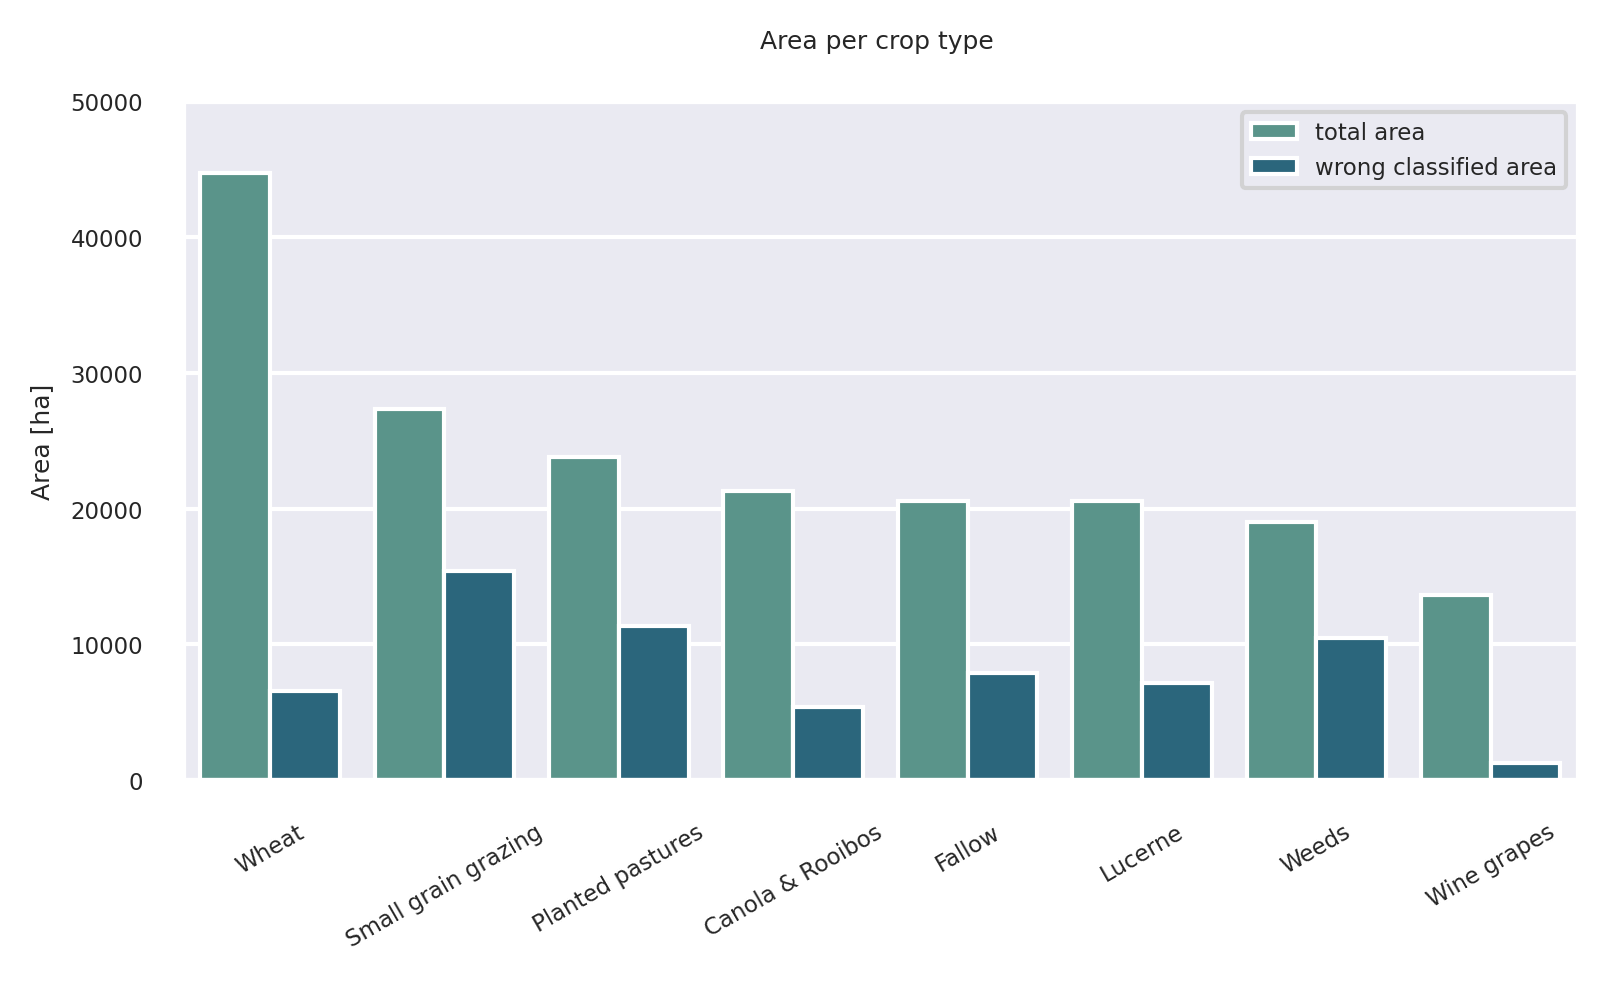

In [ ]:
plot_label_area(melted_df)

In [ ]:
# melt the data frame for plotting
area_ha_df_1 = pd.concat([cal_missclas_areas["label"], cal_missclas_areas["total area"]], axis=1)
area_ha_df_2 = pd.concat([cal_missclas_areas["label"], cal_missclas_areas["wrong classified area"]], axis=1)

In [ ]:
def plot_label_area(df_1, df_2): 
  # create a color map for the two data types
  cmap = sns.color_palette("crest", 2)
  ax = sns.barplot(data=df_1, x="label", y="total area", color=cmap[0])
  ax = sns.barplot(data=df_2, x="label", y="wrong classified area", color=cmap[1])

  # set chart labels
  ax.set_title('Area per crop type \n')
  ax.set_xlabel('')
  ax.set_ylabel('Area [ha]')

  # set the ticket labels
  plt.yticks(rotation=0) 
  plt.ylim(0, 50000)
  plt.xticks(rotation=30, horizontalalignment='center')

  # display the bar chart of the label accuracies
  plt.show()

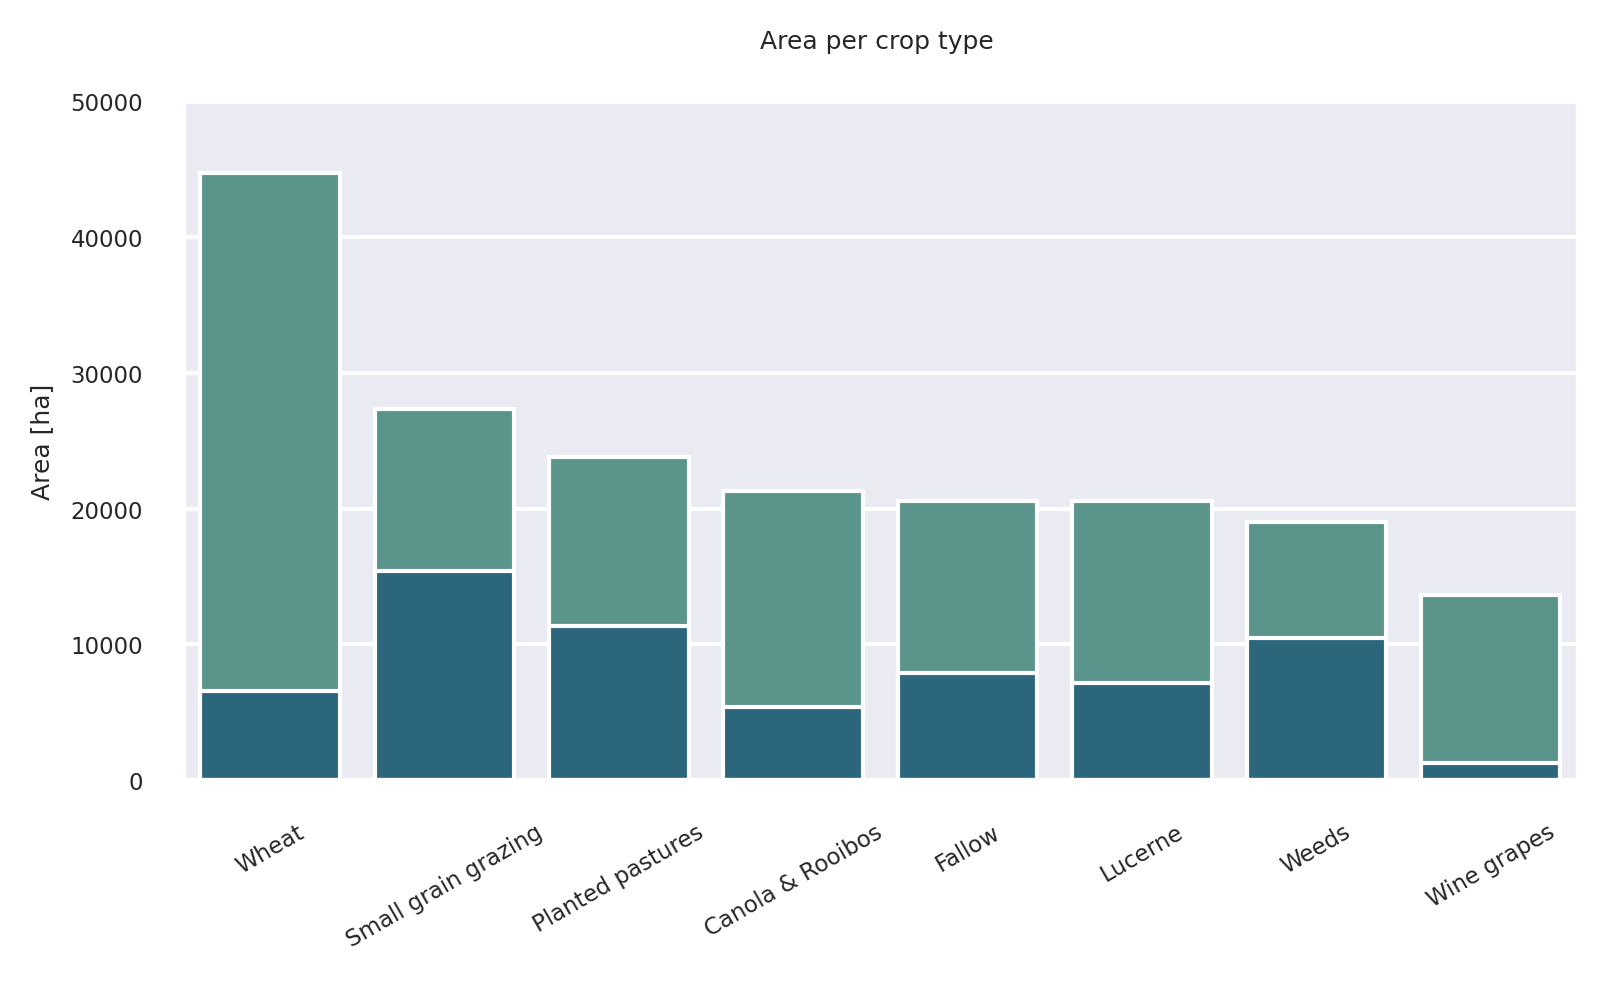

In [ ]:
plot_label_area(area_ha_df_1, area_ha_df_2)

---
## Use the model on only one month of data


In [ ]:
# get the train and test data for only one month
df_train_month = df_train[[s for s in df_train.columns if '_11' in s]]
df_train_month["field_size"] = df_train["field_size"]
df_test_month = df_test[[s for s in df_test.columns if '_11' in s]]
df_test_month["field_size"] = df_test["field_size"]

In [ ]:
# get X for the train and validation data
X_train = df_train_month
X_val = df_test_month

# get y for the train and validation data
y_train = df_train["label"]
y_train = y_train.astype(int)
y_val = df_test["label"]
y_val = y_val.astype(int)

# set the class labels from 0 to 8 
y_train = y_train-1
y_val = y_val-1

In [ ]:
X_train.head()

,B05_11,homogeneity_11,contrast_11,PVR_11,B11_11,VARI_green_11,MNSI_11,B02_11,B12_11,B09_11,...,B03_11,NDRE_11,correlation_11,SIPI2_11,B07_11,GARI_11,B06_11,B04_11,B08_11,field_size
0,60.103753,0.000000,0.000000,-0.163035,108.156735,-0.230034,38.480508,26.362030,83.796910,77.640177,...,37.812362,0.128579,1.000000,-0.912282,72.807947,81.275208,67.143488,52.565120,81.196470,151
1,79.578805,0.485758,4.205397,-0.199427,113.522514,-0.269660,45.333901,30.736414,86.229038,93.861024,...,46.661102,0.084976,0.117760,-1.585534,89.039985,102.145500,83.809392,69.629271,94.514750,644
2,94.650908,0.508425,3.369923,-0.169475,143.630828,-0.233421,51.726299,40.167746,128.347796,106.080527,...,60.846719,0.056937,0.184785,-1.902605,103.786053,107.826876,99.699265,85.666882,109.695809,579
3,60.005952,0.389199,12.112500,-0.115661,105.696430,-0.167433,32.750016,31.458333,91.327380,64.499998,...,44.958334,0.036299,-0.062789,-1.584824,65.321426,57.420178,64.059524,56.720238,72.660715,42
4,56.456141,0.424396,9.619048,-0.114271,104.175437,-0.177567,42.672930,31.447369,92.263160,79.298245,...,38.973685,0.168309,-0.038665,-0.767568,67.508772,71.152264,62.543859,49.052631,72.543862,38


In [ ]:
X_val.head()

,B05_11,homogeneity_11,contrast_11,PVR_11,B11_11,VARI_green_11,MNSI_11,B02_11,B12_11,B09_11,...,B03_11,NDRE_11,correlation_11,SIPI2_11,B07_11,GARI_11,B06_11,B04_11,B08_11,field_size
0,68.831298,0.378303,6.327342,-0.182562,104.174165,-0.252742,42.374414,28.911634,76.798523,84.444732,...,42.448265,0.102117,0.003299,-1.383187,77.964333,89.567475,72.775384,60.769281,83.445373,778
1,41.296867,0.411353,5.637489,-0.204366,89.529868,-0.275836,26.436376,15.661633,79.386019,52.799999,...,24.000672,0.122334,0.122443,-1.473741,46.795974,55.634129,43.718344,36.300784,50.307495,2980
2,101.278569,0.463322,4.296510,-0.140922,152.525559,-0.207325,59.765542,51.369184,139.723017,115.669832,...,69.056109,0.065949,0.410596,-1.817306,108.959560,104.435073,104.334441,91.913976,114.428853,1404
3,55.607090,0.459472,4.522632,-0.204232,114.163826,-0.285052,33.480435,22.088724,105.806290,70.309180,...,31.137080,0.117286,0.343407,-1.128531,64.824476,75.303469,61.060267,47.156551,69.255758,2003
4,59.753727,0.393566,6.220669,-0.172771,111.461089,-0.235140,38.798092,23.370922,90.112300,77.395618,...,36.328983,0.128475,0.241686,-1.136449,69.797297,83.154713,65.042871,51.477632,76.352517,1073


In [ ]:
# initialize a default GradientBoostingClassifier
xgb = XGBClassifier(
    objective='multi:softmax', 
    n_estimators=1900,
    random_state=RSEED,
    disable_default_eval_metric=1,
    gpu_id=0,
    tree_method='gpu_hist',
    max_depth=3,
    min_child_weight=2,
    gamma=3.535720977345191,
    colsample_bytree=0.6362412959605761,
    learning_rate=0.05986321632365238,
    reg_lambda=10.181700840893257,
    reg_alpha=8.017165700677694,
    subsample=0.34236532966944233,
    scale_pos_weight=1
    )
xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.6362412959605761,
              disable_default_eval_metric=1, gamma=3.535720977345191, gpu_id=0,
              learning_rate=0.05986321632365238, min_child_weight=2,
              n_estimators=1900, objective='multi:softprob', random_state=42,
              reg_alpha=8.017165700677694, reg_lambda=10.181700840893257,
              subsample=0.34236532966944233, tree_method='gpu_hist')

In [ ]:
# predict the absolute classes and probabilities
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)

# predict the probabilities for each  class
y_proba_train = xgb.predict_proba(X_train)
y_proba_val = xgb.predict_proba(X_val)

print("---" * 12)
print(f"Accuracy on train data: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Accuracy on test data: {accuracy_score(y_val, y_pred_val):.4f}")
print("---" * 12)
print(f'F1-score on train data: {f1_score(y_train, y_pred_train, average="macro"):.4f}')
print(f'F1-score on test data: {f1_score(y_val, y_pred_val, average="macro"):.4f}')
print("---" * 12)
print(f"Cross-entropy on train data: {log_loss(y_train, y_proba_train):.4f}")
print(f"Cross-entropy on test data: {log_loss(y_val, y_proba_val):.4f}")
print("---" * 12)

------------------------------------
Accuracy on train data: 0.5729
Accuracy on test data: 0.5544
------------------------------------
F1-score on train data: 0.5639
F1-score on test data: 0.4839
------------------------------------
Cross-entropy on train data: 1.2053
Cross-entropy on test data: 1.2602
------------------------------------


In [ ]:
def plot_confusion_matrix(xgb_cm:confusion_matrix, labels:list):
    """Plots a nicely formatted confusion matrix. 

    Args:
        xgb_cm (sklearn.metrics.confusion_matrix): The confusion matrix to be plotted.
        labels (list): List of the class label names.
    """

    # setup the heatmap of the confusion matrix
    ax = sns.heatmap(xgb_cm, annot=True, cmap=cmap, fmt='g')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    # set the ticket labels
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=30, horizontalalignment='center') 

    # display the confusion matrix
    plt.show()

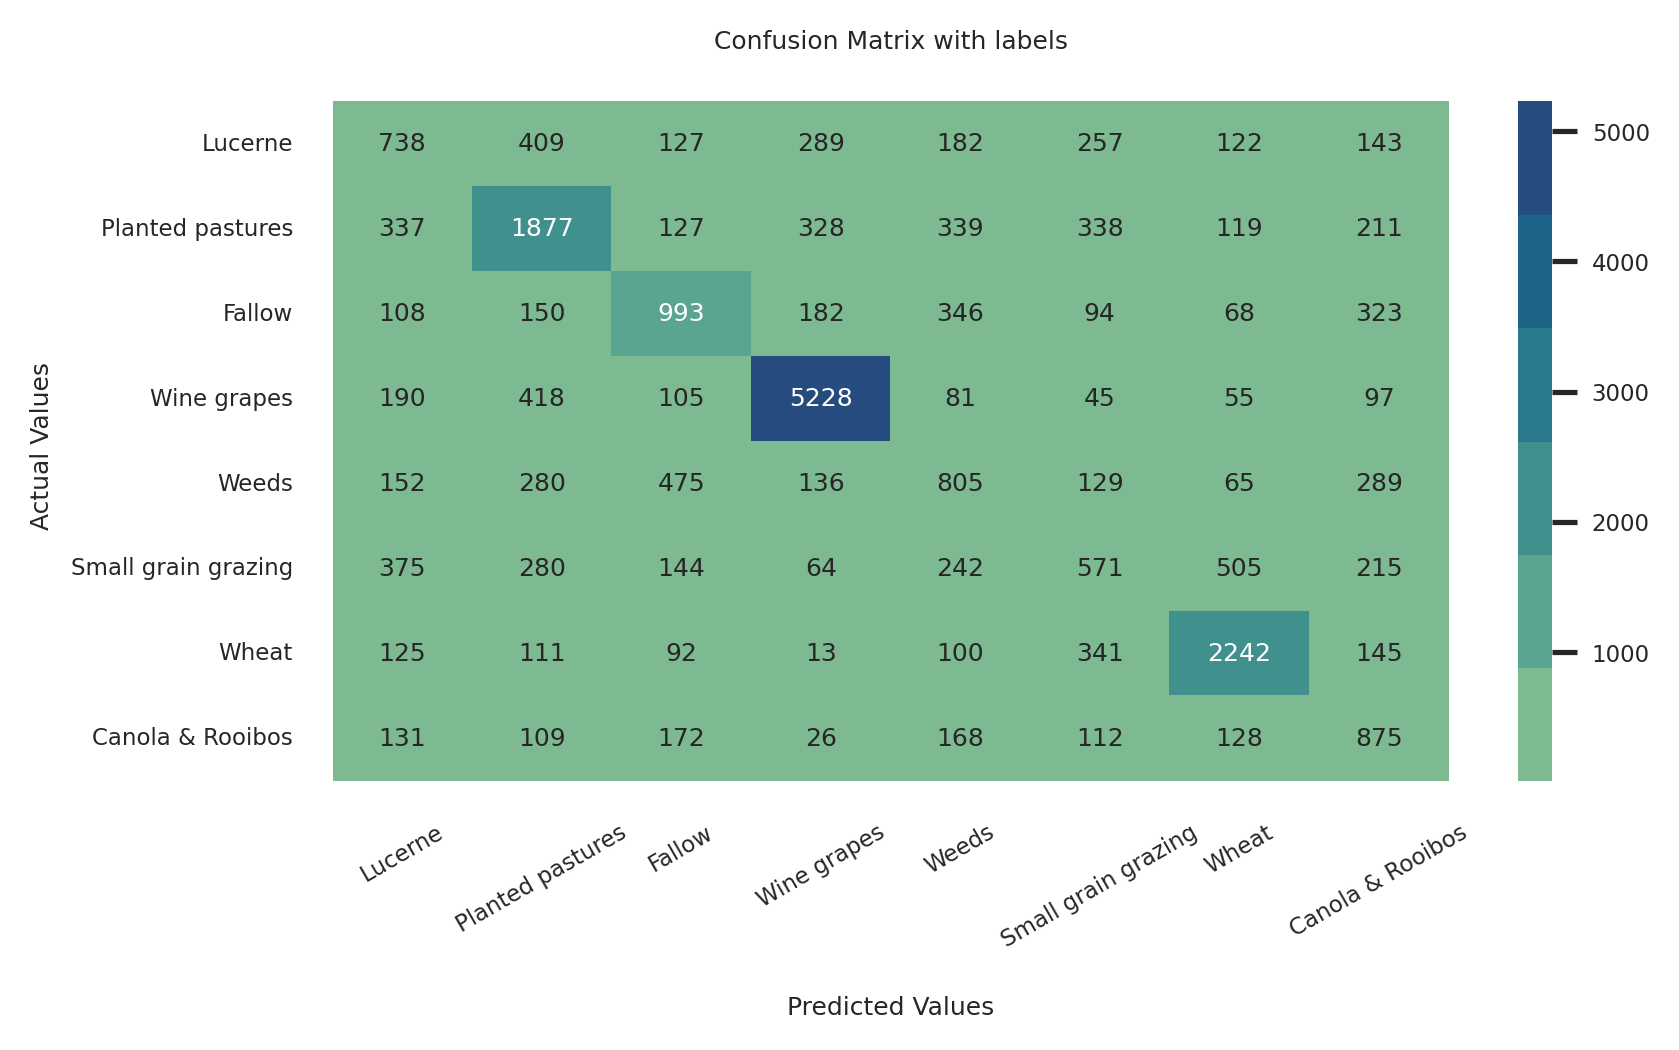

In [ ]:
# build the confusion matrix
xgb_cm = confusion_matrix(y_val, y_pred_val)

# set the class labels to the actual crop types
labels = [
          'Lucerne', 
          'Planted pastures', 
          'Fallow', 
          'Wine grapes', 
          'Weeds', 
          'Small grain grazing', 
          'Wheat', 
          'Canola & Rooibos'
]

# plot the confusion matrix of the validation data
plot_confusion_matrix(xgb_cm, labels)

In [ ]:
accuracies_df = get_label_accuracies(xgb_cm, labels)

In [ ]:
def plot_label_accuracy(df):
    # plot Searborn bar chart
    cmap = sns.color_palette("crest", 100)

    c_palette = [
                 cmap[0] if x >= 0.8
                 else cmap[50] if x >= 0.6
                 else cmap[99]
                 for x in df.accuracy
    ]

    ax = sns.barplot(
      data=df, 
      x='crop_type', 
      y='accuracy', 
      palette=c_palette
    )

    # do the annotation on each bar
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'), 
                      (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')


    # set chart labels
    ax.set_title('Accuracy of the different crop types\n')
    ax.set_xlabel('')
    ax.set_ylabel('Accuracy')

    # set the ticket labels
    plt.yticks(rotation=0) 
    plt.ylim(0, 1.1)
    plt.xticks(rotation=30, horizontalalignment='center')

    # display the bar chart of the label accuracies
    plt.show()

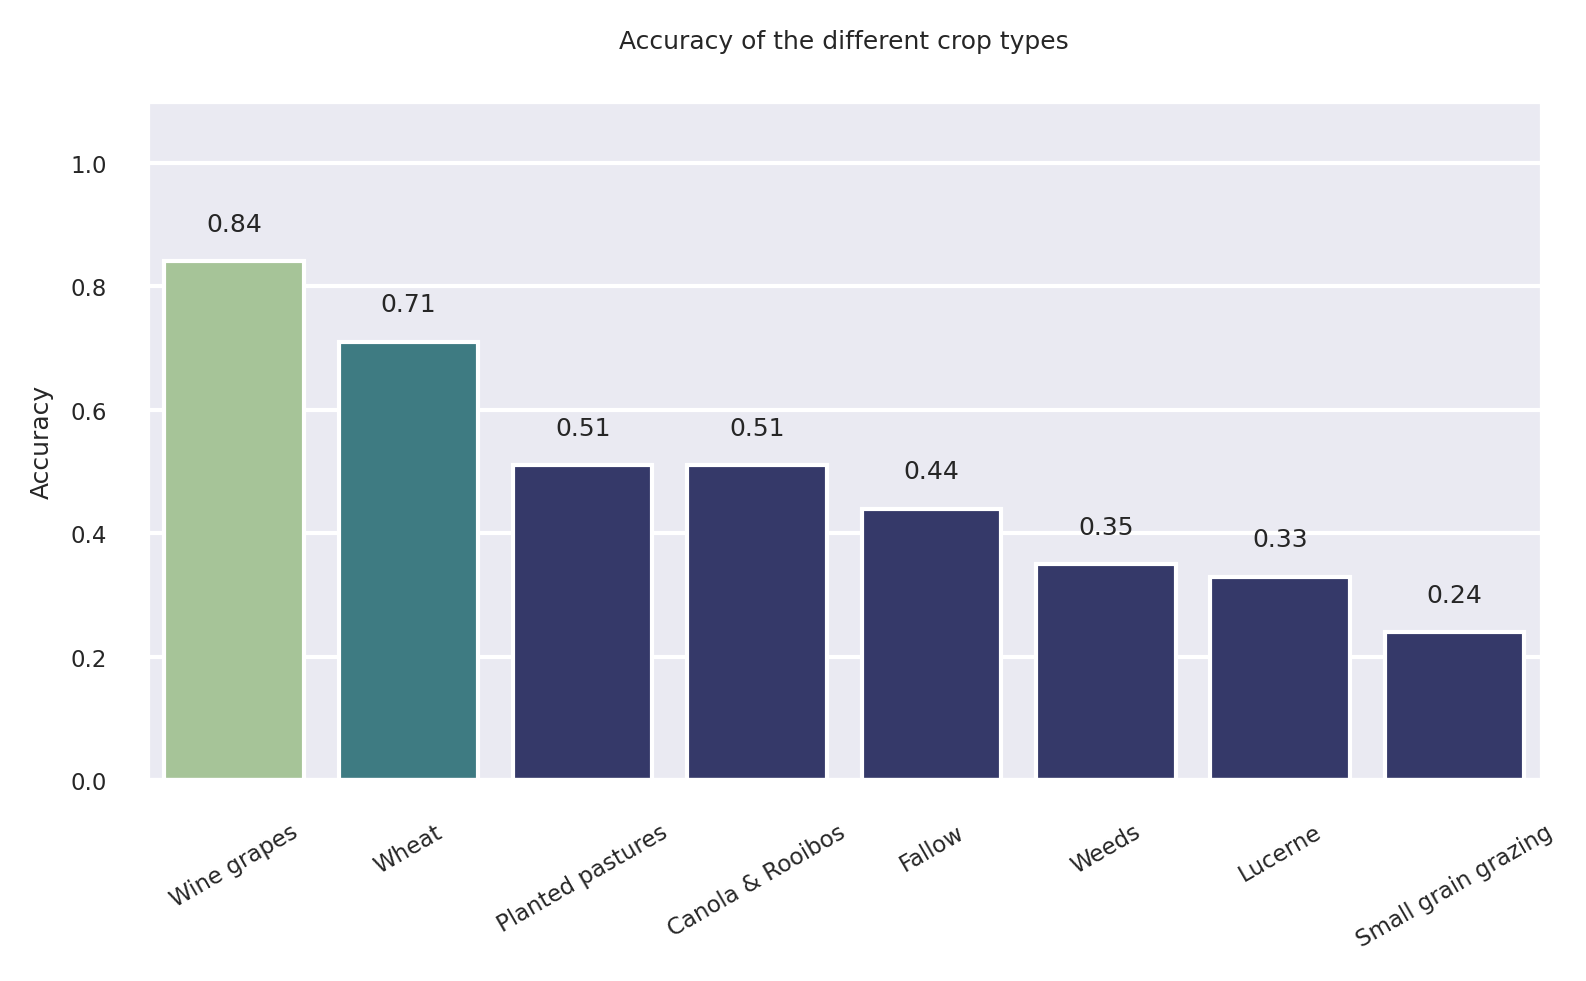

In [ ]:
plot_label_accuracy(accuracies_df)

In [ ]:
def calculate_missclassified_area(df, y, y_pred):
  # compare y and y_pred and get the right fields
  right_classified = (np.array(y) == np.array(y_pred)) 
  df["right_classified"] = right_classified
  # get all labels
  labels = df["label"].unique().tolist()
  # create containers for the results 
  total_areas = []
  wrong_classified_areas = []
  # iterate over the labels and calculate the areas
  for label in labels:
    label_df = df[df["label"]==label]
    total_area = label_df["field_size"].sum()
    total_areas.append(total_area)
    wrong_classified_area = label_df[label_df["right_classified"]==False]["field_size"].sum()
    wrong_classified_areas.append(wrong_classified_area)

  # create data frame from the results
  results = pd.DataFrame(
    {
        "label": labels,
        "total_area_px": total_areas,
        "wrong_classified_area_px": wrong_classified_areas
    }
  )
  results["wrong_classified_area_perc"] = (results["wrong_classified_area_px"] / results["total_area_px"]) *100
  return results

In [ ]:
cal_missclas_areas = calculate_missclassified_area(df_test, y_val, y_pred_val)

# set the class labels to the actual crop types
labels = {
          1: 'Lucerne', 
          2: 'Planted pastures', 
          3: 'Fallow', 
          4: 'Wine grapes', 
          5: 'Weeds', 
          6: 'Small grain grazing', 
          7: 'Wheat', 
          8: 'Canola & Rooibos'
}

cal_missclas_areas = cal_missclas_areas.replace({"label": labels})

In [ ]:
# calculate the area in ha
cal_missclas_areas["total area"] = cal_missclas_areas["total_area_px"]*0.01
cal_missclas_areas["wrong classified area"] = cal_missclas_areas["wrong_classified_area_px"]*0.01
cal_missclas_areas.sort_values("total area", ascending=False, inplace=True)

# melt the data frame for plotting
area_ha_df = pd.concat([cal_missclas_areas["label"], cal_missclas_areas["total area"], cal_missclas_areas["wrong classified area"]], axis=1)
melted_df = area_ha_df.melt(id_vars="label")
melted_df.columns = ["crop_type", "area_type", "area_ha"]

In [ ]:
def plot_label_area(df_1, df_2): 
  # create a color map for the two data types
  cmap = sns.color_palette("crest", 2)
  ax = sns.barplot(data=df_1, x="label", y="total area", color=cmap[0])
  ax = sns.barplot(data=df_2, x="label", y="wrong classified area", color=cmap[1])

  # set chart labels
  ax.set_title('Area per crop type \n')
  ax.set_xlabel('')
  ax.set_ylabel('Area [ha]')

  # set the ticket labels
  plt.yticks(rotation=0) 
  plt.ylim(0, 50000)
  plt.xticks(rotation=30, horizontalalignment='center')

  # display the bar chart of the label accuracies
  plt.show()

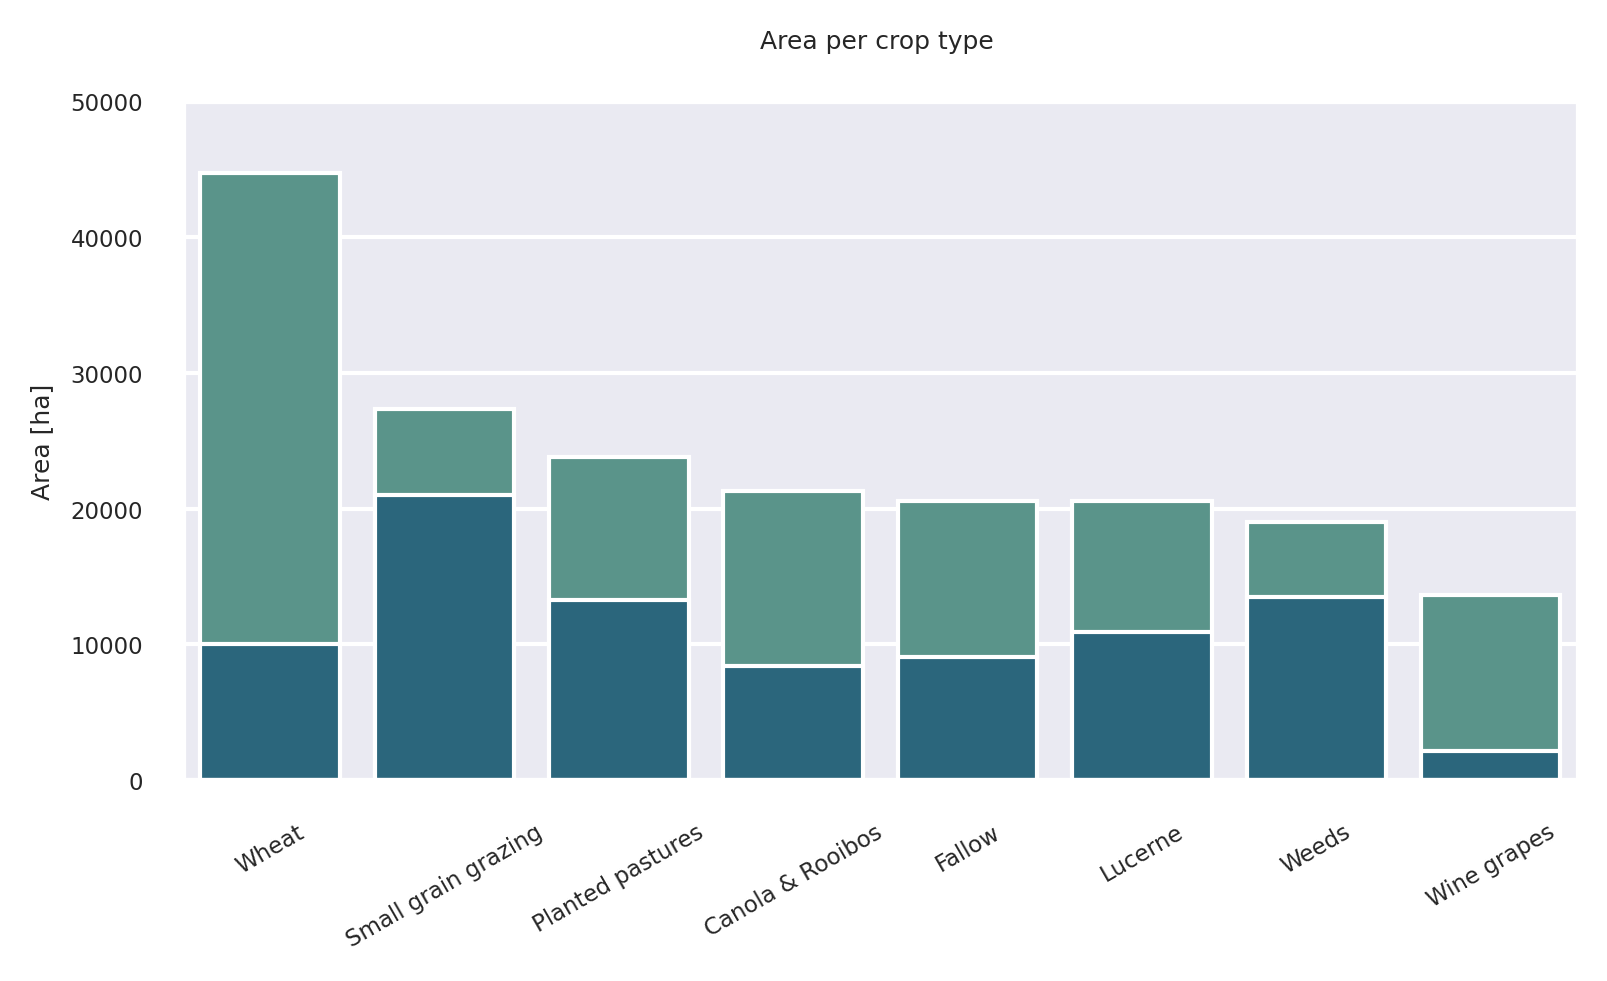

In [ ]:
# melt the data frame for plotting
area_ha_df_1 = pd.concat([cal_missclas_areas["label"], cal_missclas_areas["total area"]], axis=1)
area_ha_df_2 = pd.concat([cal_missclas_areas["label"], cal_missclas_areas["wrong classified area"]], axis=1)
plot_label_area(area_ha_df_1, area_ha_df_2)